AI-Based Resume Screening and Candidate Ranking System
Recruiters manually screen hundreds of resumes for each job posting. This process is:

Time consuming

Biased

Inefficient

The objective of this project is to develop an AI-powered resume screening system that:

Matches resumes with job descriptions

Ranks candidates based on similarity

Provides explainable matching scores

# Step 1: Install Libraries

In [26]:
!pip install datasets sentence-transformers scikit-learn pandas matplotlib seaborn

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Step 2 -Load Kaggle Resume Dataset from HuggingFace

In [28]:
from datasets import load_dataset
import pandas as pd

dataset = load_dataset("Divyaamith/Kaggle-Resume")

df = dataset["train"].to_pandas()

df.head()

Repo card metadata block was not found. Setting CardData to empty.


,ID,Resume_str,Resume_html,Category
0,16852973,HR ADMINISTRATOR/MARKETING ASSOCIATE\...,"<div class=""fontsize fontface vmargins hmargin...",HR
1,22323967,"HR SPECIALIST, US HR OPERATIONS ...","<div class=""fontsize fontface vmargins hmargin...",HR
2,33176873,HR DIRECTOR Summary Over 2...,"<div class=""fontsize fontface vmargins hmargin...",HR
3,27018550,HR SPECIALIST Summary Dedica...,"<div class=""fontsize fontface vmargins hmargin...",HR
4,17812897,HR MANAGER Skill Highlights ...,"<div class=""fontsize fontface vmargins hmargin...",HR


# STEP 3 — Basic Dataset Understanding

In [29]:
df.shape

(2484, 4)

In [30]:
df.columns

Index(['ID', 'Resume_str', 'Resume_html', 'Category'], dtype='object')

# Step 4 - EDA

In [31]:
df.isnull().sum()

,0
ID,0
Resume_str,0
Resume_html,0
Category,0


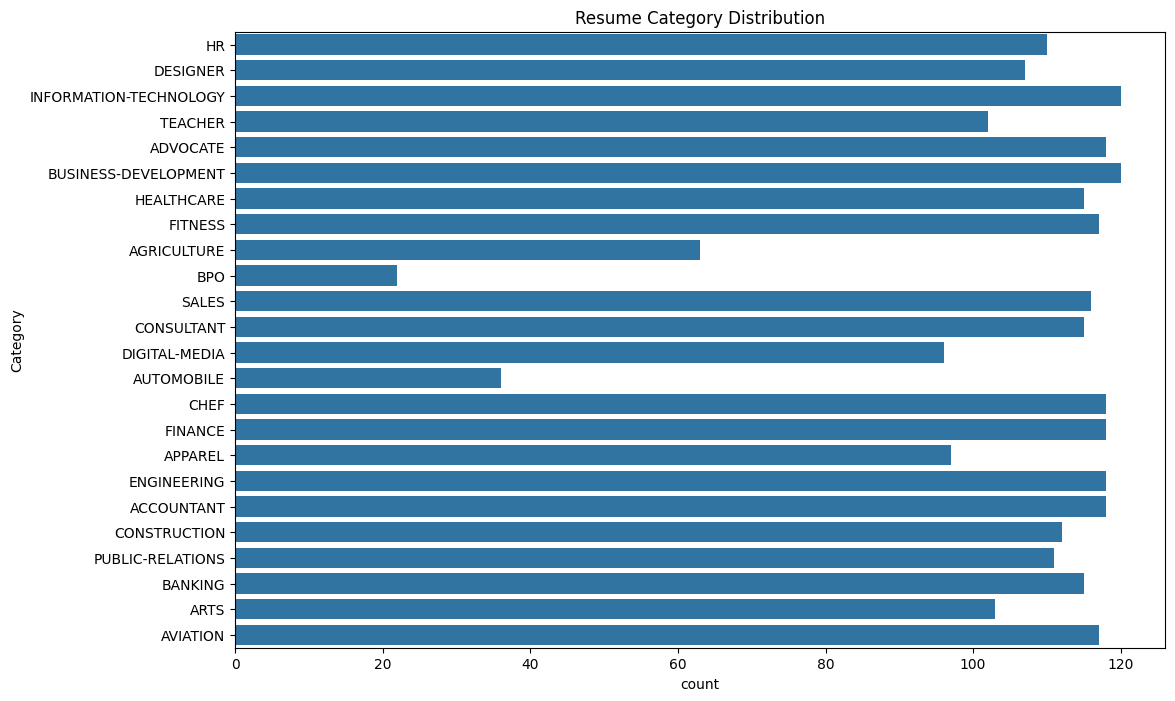

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12,8))
sns.countplot(y=df['Category'])
plt.title("Resume Category Distribution")
plt.show()

In [33]:
import re

def clean_resume(text):
    text = re.sub('http\S+\s*', ' ', text)
    text = re.sub('\S+@\S+', ' ', text)
    text = re.sub('[^a-zA-Z ]', ' ', text)
    text = re.sub('\s+', ' ', text)
    return text.lower()

df['cleaned_resume'] = df['Resume_str'].apply(clean_resume)

<>:4: SyntaxWarning: invalid escape sequence '\S'
<>:5: SyntaxWarning: invalid escape sequence '\S'
<>:7: SyntaxWarning: invalid escape sequence '\s'
<>:4: SyntaxWarning: invalid escape sequence '\S'
<>:5: SyntaxWarning: invalid escape sequence '\S'
<>:7: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipython-input-925007077.py:4: SyntaxWarning: invalid escape sequence '\S'
  text = re.sub('http\S+\s*', ' ', text)
/tmp/ipython-input-925007077.py:5: SyntaxWarning: invalid escape sequence '\S'
  text = re.sub('\S+@\S+', ' ', text)
/tmp/ipython-input-925007077.py:7: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('\s+', ' ', text)


In [34]:
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('all-MiniLM-L6-v2')

Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


In [35]:
resume_embeddings = model.encode(df['cleaned_resume'], show_progress_bar=True)

Batches:   0%|          | 0/78 [00:00<?, ?it/s]

In [36]:
job_description = """
Looking for Data Scientist with Python,
Machine Learning, Deep Learning, NLP and SQL experience.
"""

In [37]:
job_embedding = model.encode([job_description])

In [38]:
from sklearn.metrics.pairwise import cosine_similarity

similarity_scores = cosine_similarity(resume_embeddings, job_embedding)
df['similarity_score'] = similarity_scores

In [39]:
ranked_df = df.sort_values(by='similarity_score', ascending=False)

ranked_df[['Category', 'similarity_score']].head(10)

,Category,similarity_score
1762,ENGINEERING,0.546131
929,AGRICULTURE,0.455904
1194,CONSULTANT,0.437740
1127,CONSULTANT,0.428468
297,INFORMATION-TECHNOLOGY,0.420872
1722,ENGINEERING,0.402428
311,INFORMATION-TECHNOLOGY,0.399796
2242,BANKING,0.399430
1932,CONSTRUCTION,0.397226
2395,AVIATION,0.395482


In [40]:
top_candidates = ranked_df.head(5)

for i, row in top_candidates.iterrows():
    print("Category:", row['Category'])
    print("Match Score:", round(row['similarity_score'], 4))
    print("-"*40)

Category: ENGINEERING
Match Score: 0.5461
----------------------------------------
Category: AGRICULTURE
Match Score: 0.4559
----------------------------------------
Category: CONSULTANT
Match Score: 0.4377
----------------------------------------
Category: CONSULTANT
Match Score: 0.4285
----------------------------------------
Category: INFORMATION-TECHNOLOGY
Match Score: 0.4209
----------------------------------------


In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

vectorizer = TfidfVectorizer(max_features=5000)

X = vectorizer.fit_transform(df['cleaned_resume'])
y = df['Category']

clf = LogisticRegression(max_iter=1000)
clf.fit(X, y)

LogisticRegression(max_iter=1000)

In [42]:
jd_vector = vectorizer.transform([job_description])
predicted_category = clf.predict(jd_vector)

print("Predicted Job Category:", predicted_category[0])

Predicted Job Category: DESIGNER


In [43]:
filtered_df = df[df['Category'] == predicted_category[0]]

In [44]:
ranked_df['Category'].head(20).value_counts()

,count
Category,
INFORMATION-TECHNOLOGY,5
CONSULTANT,4
ENGINEERING,3
AUTOMOBILE,2
AVIATION,2
BANKING,1
AGRICULTURE,1
CONSTRUCTION,1
BPO,1


In [46]:
!pip install streamlit pyngrok

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.1/9.1 MB 37.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 65.2 MB/s eta 0:00:00
  Attempting uninstall: cachetools
    Found existing installation: cachetools 7.0.1
    Uninstalling cachetools-7.0.1:
      Successfully uninstalled cachetools-7.0.1


In [54]:
!streamlit run app.py &

Usage: streamlit run [OPTIONS] [TARGET] [ARGS]...
Try 'streamlit run --help' for help.

Error: Invalid value: File does not exist: app.py


In [55]:
!pwd

/content


In [56]:
!ls

drive  sample_data
